# Universal $\mathcal{P}_1(\mathbb{R})$-Deep Neural Model (Type A)
---

---
# Training Algorithm:
---
## 1) Generate Data:
Generates the empirical measure $\sum_{n=1}^N \delta_{X_T(\omega_n)}$ of $X_T$ conditional on $X_0=x_0\in \mathbb{R}$ *($x_0$ and $T>0$ are user-provided)*.

## 2) Get "Sample Barycenters":
Let $\{\mu_n\}_{n=1}^N\subset\mathcal{P}_1(\mathbb{R}^d)$.  Then, the *sample barycenter* is defined by:
1. $\mathcal{M}^{(0)}\triangleq \left\{\hat{\mu}_n\right\}_{n=1}^N$,
2. For $1\leq n\leq \mbox{N sample barycenters}$: 
    - $
\mu^{\star}\in \underset{\tilde{\mu}\in \mathcal{M}^{(n)}}{\operatorname{argmin}}\, \sum_{n=1}^N \mathcal{W}_1\left(\mu^{\star},\mu_n\right),
$
    - $\mathcal{M}^{(n)}\triangleq \mathcal{M}^{(n-1)} - \{\mu^{\star}\},$
*i.e., the closest generated measure form the random sample to all other elements of the random sample.*

---
**Note:** *We simplify the computational burden of getting the correct classes by putting this right into this next loop.*

## 3) Train Deep Classifier:
$\hat{f}\in \operatorname{argmin}_{f \in \mathcal{NN}_{d:N}^{\star}} 
\sum_{x \in \mathbb{X}}
\, 
\mathbb{H}
\left(
    \operatorname{Softmax}_N\circ f(x)_n| I\left\{W_1(\hat{\mu}_n,\mu_x),\inf_{m\leq N} W_1(\hat{\mu}_m,\mu_x)\right\}
\right);
$
where $\mathbb{H}$ is the categorical cross-entropy.  

---
---
---
## Notes - Why the procedure is so computationally efficient?
---
 - The sample barycenters do not require us to solve for any new Wasserstein-1 Barycenters; which is much more computationally costly,
 - Our training procedure never back-propages through $\mathcal{W}_1$ since steps 2 and 3 are full-decoupled.  Therefore, training our deep classifier is (comparatively) cheap since it takes values in the standard $N$-simplex.

---

## Meta-Parameters

### Visualization

In [1]:
# How many random polulations to visualize:
Visualization_Size = 4

### Quantization
*This hyperparameter describes the proportion of the data used as sample-barycenters.*

In [2]:
Quantization_Proportion = 0.5

### Simulation

#### Ground Truth:
*The build-in Options:*
- rSDE 
- pfBM
- 2lnflow

In [3]:
groud_truth = "rSDE"

#### Grid Hyperparameter(s)

In [4]:
## Monte-Carlo
N_Euler_Maruyama_Steps = 100
N_Monte_Carlo_Samples = 10**4
N_Monte_Carlo_Samples_Test = 10**4 # How many MC-samples to draw from test-set?

# End times for Time-Grid
T_end = 1
T_end_test = 1.5


## Grid
N_Grid_Finess = 2
Max_Grid = 1

**Note**: Setting *N_Quantizers_to_parameterize* prevents any barycenters and sub-sampling.

#### Mode: Code-Testin Parameter(s)

In [5]:
trial_run = True

### Meta-parameters

In [6]:
# Test-size Ratio
test_size_ratio = .25

## Simulation from Measure-Valued $2$-Parameter Gaussian Flow
$$
X_{t,x} \sim \mathcal{N}\left(\alpha(t,x),\beta(t,x)\right).
$$

**Note:** *$\alpha$ and $\beta$ are specified below in the SDE Example*.

## Simulation from Rough SDE
Simulate via Euler-M method from:
$$ 
X_T = x + \int_0^T \alpha(s,x)ds + \int_0^T((1-\eta)\beta(s,x)+\eta\sigma_s^H)dW_s.
$$

### Drift

In [7]:
def alpha(t,x):
    return (.1 - .5*(0.1**2))*t#t*np.sin(math.pi*x) #+ np.exp(-t)

### Volatility

In [8]:
def beta(t,x):
    return 0.1#(1+t) + np.cos(x)

### Roughness Meta-parameters

In [9]:
Rougness = 0.9 # Hurst Parameter
Ratio_fBM_to_typical_vol = 0 # $\eta$ in equation above.

## Perturbed Fractional Brownian Motion
Simulate from:
$$
X_t^x(\omega) = f_1(x)f_2(t) + B_t^H(\omega).
$$

In [10]:
def field_dirction_x(x):
    return x*np.cos(x)

def finite_variation_t(t):
    return t*(np.sin(math.pi*t) + np.exp(-t))

### Get Paths

In [11]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [12]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('CV_Grid.py').read())
# Load Helper Function(s)
# %run ParaGAN_Backend.ipynb
exec(open('Helper_Functions.py').read())
# Import time separately
import time

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready


### Set Seed

In [13]:
random.seed(2021)
np.random.seed(2021)
tf.random.set_seed(2021)

## Get Internal (Hyper)-Parameter(s)
*Initialize the hyperparameters which are fully-specified by the user-provided hyperparameter(s).*

### Initialize Grid
This is $\mathbb{X}$ and it represents the grid of initial states.

In [14]:
# Get Input Data
#----------------------------------------------------------#
## Train
x_Grid = np.arange(start=-Max_Grid,
                   stop=Max_Grid,
                   step=(2*Max_Grid/N_Grid_Finess))
t_Grid = np.linspace(0,T_end,(1+N_Euler_Maruyama_Steps))
## Get Number of Instances in Grid: Training
N_Grid_Instances_x = len(x_Grid)
N_Grid_Instances_t = len(t_Grid)
N_Grid_Instances = N_Grid_Instances_x*N_Grid_Instances_t 

#----------------------------------------------------------#
## Test
x_Grid_test = np.sort(np.random.uniform(low=-Max_Grid,
                                        high=Max_Grid,
                                        size = max(round(len(x_Grid)*test_size_ratio),2)))
t_Grid_test = np.linspace(T_end+0.001,T_end_test,(1+round(N_Euler_Maruyama_Steps*test_size_ratio)))
# Get Number of Instances in Grid: Test
N_Grid_Instances_x_test = len(x_Grid_test)
N_Grid_Instances_t_test = len(t_Grid_test)
N_Grid_Instances_test = N_Grid_Instances_x_test*N_Grid_Instances_t_test
#----------------------------------------------------------#

# Updater User
print("\u2022 Grid Instances: ", N_Grid_Instances, "and :",N_Grid_Instances_test," Testing instances.")

• Grid Instances:  202 and : 52  Testing instances.


### Initialize Counting Parameters
Initialize the "conting" type parameters which will help us to determine the length of loops and to intialize object's size later on.  

In [15]:
# Get Internal (Counting) Parameters
N_Quantizers_to_parameterize = round(Quantization_Proportion*N_Grid_Instances)
N_Elements_Per_Cluster = int(round(N_Grid_Instances/N_Quantizers_to_parameterize))

# Update User
print("\u2022",N_Quantizers_to_parameterize," Centers will be produced; from a total datasize of: ",N_Grid_Finess,
      "!  (That's ",Quantization_Proportion,
      " percent).")
print("\u2022 Each Wasserstein-1 Ball should contain: ",
      N_Elements_Per_Cluster, 
      "elements from the training set.")

• 101  Centers will be produced; from a total datasize of:  2 !  (That's  0.5  percent).
• Each Wasserstein-1 Ball should contain:  2 elements from the training set.


---

### Simulate from non-Markovian SDE with rough volatility:
$d X_t = \alpha(t,X_t)dt + ((1-\eta)\beta(t,X_t)+\eta\sigma_t^H)dW_t ;\qquad X_0 =x$
Where $(\sigma_t^H)_t$ is a fBM with Hurst parameter $H=0.01$ and $\eta \in [0,1]$ controlls the 'abount of long-term memory and roughness in $X_t$'.

### Define Sampler - Data-Generator

Generates the empirical measure $\sum_{n=1}^N \delta_{X_T(\omega_n)}$ of $X_T$ conditional on $X_0=x_0\in \mathbb{R}$ *($x_0$ and $T>0$ are user-provided)*.

In [16]:
def Euler_Maruyama_Generator(x_0,
                             N_Euler_Maruyama_Steps = 10,
                             N_Monte_Carlo_Samples = 100,
                             T = 1,
                             Hurst = 0.1,
                             Ratio_fBM_to_typical_vol = 0.5): 
    
    #----------------------------#    
    # DEFINE INTERNAL PARAMETERS #
    #----------------------------#
    # Initialize Empirical Measure
    X_T_Empirical = np.zeros([N_Euler_Maruyama_Steps,N_Monte_Carlo_Samples])


    # Internal Initialization(s)
    ## Initialize current state
    n_sample = 0
    ## Initialize Incriments
    dt = T/N_Euler_Maruyama_Steps
    sqrt_dt = np.sqrt(dt)

    #-----------------------------#    
    # Generate Monte-Carlo Sample #
    #-----------------------------#
    while n_sample < N_Monte_Carlo_Samples:
        # Reset Step Counter
        t = 1
        # Initialize Current State 
        X_current = x_0
        # Generate roughness
        sigma_rough = FBM(n=N_Euler_Maruyama_Steps, hurst=0.75, length=1, method='daviesharte').fbm()
        # Perform Euler-Maruyama Simulation
        while t<(N_Euler_Maruyama_Steps-1):
            # Update Internal Parameters
            ## Get Current Time
            t_current = t*(T/N_Euler_Maruyama_Steps)

            # Update Generated Path
            drift_t = alpha(t_current,X_current)*dt
            vol_t = ((1-Ratio_fBM_to_typical_vol)*beta(t_current,X_current)+Ratio_fBM_to_typical_vol*(sigma_rough[t]))*np.random.normal(0,sqrt_dt)
            X_current = X_current + drift_t + vol_t

            # Update Counter (EM)
            t = t+1

            # Update Empirical Measure
            X_T_Empirical[t,n_sample] = X_current

        # Update Counter (MC)
        n_sample = n_sample + 1

    return X_T_Empirical

---

### Initializations

In [17]:
# Initialize List of Barycenters
Wasserstein_Barycenters = []
# Initialize Terminal-Time Empirical Measures
## Training Outputs
measures_locations_list = []
measures_weights_list = []
## Testing Outputs
measures_locations_test_list = []
measures_weights_test_list = []
# Grid (Training and Testing inputs (t,x))
X_train = []
X_test = []

# Initialize (Empirical) Weight(s)
measure_weights = np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples
measure_weights_test = np.ones(N_Monte_Carlo_Samples_Test)/N_Monte_Carlo_Samples_Test
# Initialize Quantizer
Init_Quantizer_generic = np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples

## Generate $\{\hat{\nu}^{N}_{T,x}\}_{x \in \mathbb{X}}$ Build Wasserstein Cover

#### Get Data

### Gaussian $2$-Parameter Flow

In [18]:
if groud_truth == "2lnflow":
    print("Direct Sampling from Distribution for 2-Parameter Flow.")
    #----------------------------------------------------------------------------------------------#
    # Update User
    print("===================================")
    print("Start Simulation Step: Training Set")
    print("===================================")
    # Perform Monte-Carlo Data Generation
    for i in tqdm(range(N_Grid_Instances_x)):
        x_loop = x_Grid[i]
        # Generate finite-variation path (since it stays unchanged)
        for j in range(N_Grid_Instances_t):
            t_loop = t_Grid[j]
            measures_locations_loop = np.random.lognormal(alpha(t_loop,x_loop),
                                                          beta(t_loop,x_loop),
                                                          N_Monte_Carlo_Samples)
        
            # Update Inputs
            if (i==0 and j==0):
                X_train = np.array([t_loop,x_loop]).reshape(1,-1)
            else:
                X_train = np.append(X_train,np.array([t_loop,x_loop]).reshape(1,-1),axis=0)
        
            # Append to List
            measures_locations_list = measures_locations_list + [measures_locations_loop]
            measures_weights_list.append(measure_weights)
        
        
    
    # Update User
    print("==================================")
    print("Done Simulation Step: Training Set")
    print("==================================")


print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")

if groud_truth == "2lnflow":
    print("===============================")
    print("Start Simulation Step: Test Set")
    print("===============================")
    # Perform Monte-Carlo Data Generation
    for i in tqdm(range(N_Grid_Instances_x_test)):
        x_loop = x_Grid_test[i]
        # Generate finite-variation path (since it stays unchanged)
        for j in range(N_Grid_Instances_t_test):
            t_loop = t_Grid_test[j]
            measures_locations_loop = np.random.lognormal(alpha(t_loop,x_loop),
                                                          beta(t_loop,x_loop),
                                                          N_Monte_Carlo_Samples_Test)
        
            # Update Inputs
            if (i==0 and j==0):
                X_test = np.array([t_loop,x_loop]).reshape(1,-1)
            else:
                X_test = np.append(X_test,np.array([t_loop,x_loop]).reshape(1,-1),axis=0)
        
            # Append to List
            measures_locations_test_list = measures_locations_test_list + [measures_locations_loop]
            measures_weights_test_list.append(measure_weights_test)
    print("==============================")
    print("Done Simulation Step: Test Set")
    print("==============================")

===============================--------------------------------------===============================
===============================--------------------------------------===============================
===============================--------------------------------------===============================


### Rough SDE Simulator:

In [19]:
if groud_truth == "rSDE":
    print("Using Euler-Maruyama distritization + Monte-Carlo Sampling.")
    #----------------------------------------------------------------------------------------------#
    # Update User
    print("===================================")
    print("Start Simulation Step: Training Set")
    print("===================================")
    # Initialize fBM Generator
    fBM_Generator = FBM(n=N_Euler_Maruyama_Steps, hurst=0.75, length=1, method='daviesharte')

    # Perform Monte-Carlo Data Generation
    for i in tqdm(range(N_Grid_Instances_x)):
        # Get x
        field_loop_x = field_dirction_x(x_Grid[i])
        # Get omega and t
        # Generate finite-variation path (since it stays unchanged)
        finite_variation_path = finite_variation_t(t_Grid).reshape(-1,1) +field_loop_x
        # Simulate Paths
        paths_loop = Euler_Maruyama_Generator(x_0=x_Grid[i],
                                              N_Euler_Maruyama_Steps = len(t_Grid),
                                              N_Monte_Carlo_Samples = N_Monte_Carlo_Samples,
                                              T = T_end,
                                              Hurst=Rougness,
                                              Ratio_fBM_to_typical_vol=Ratio_fBM_to_typical_vol)
        
        # Map numpy to list
        measures_locations_loop = paths_loop.tolist()
        # Get inputs
        X_train_loop = np.append(np.repeat(x_Grid[i],(N_Euler_Maruyama_Steps+1)).reshape(-1,1),
                                 t_Grid.reshape(-1,1),
                                 axis=1)
        
        # Append to List
        measures_locations_list = measures_locations_list + measures_locations_loop
        measures_weights_list.append(measure_weights)
        
        # Update Inputs
        if i==0:
            X_train = X_train_loop
        else:
            X_train = np.append(X_train,X_train_loop,axis=0)
    
    # Update User
    print("==================================")
    print("Done Simulation Step: Training Set")
    print("==================================")


print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")

if groud_truth == "rSDE":
    print("===============================")
    print("Start Simulation Step: Test Set")
    print("===============================")
    # Initialize fBM Generator
    fBM_Generator_test = FBM(n=(len(t_Grid_test)-1), hurst=0.75, length=1, method='daviesharte')

    # Perform Monte-Carlo Data Generation
    for i in tqdm(range(N_Grid_Instances_x_test)):
        # Get x
        field_loop_x = field_dirction_x(x_Grid_test[i])
        # Get omega and t
        # Generate finite-variation path (since it stays unchanged)
        finite_variation_path = finite_variation_t(t_Grid_test).reshape(-1,1) +field_loop_x
        paths_loop = Euler_Maruyama_Generator(x_0=x_Grid_test[i],
                                              N_Euler_Maruyama_Steps = len(t_Grid_test),
                                              N_Monte_Carlo_Samples = N_Monte_Carlo_Samples_Test,
                                              T = T_end_test,
                                              Hurst=Rougness,
                                              Ratio_fBM_to_typical_vol=Ratio_fBM_to_typical_vol)
        
        # Map numpy to list
        measures_locations_loop = paths_loop.tolist()
        # Get inputs
        X_test_loop = np.append(np.repeat(x_Grid_test[i],len(t_Grid_test)).reshape(-1,1),
                                 t_Grid_test.reshape(-1,1),
                                 axis=1)
        
        # Append to List
        measures_locations_test_list = measures_locations_test_list + measures_locations_loop
        measures_weights_test_list.append(measure_weights_test)
        
        # Update Inputs
        if i==0:
            X_test = X_test_loop
        else:
            X_test = np.append(X_test,X_test_loop,axis=0)
    print("==============================")
    print("Done Simulation Step: Test Set")
    print("==============================")

  0%|          | 0/2 [00:00<?, ?it/s]

Using Euler-Maruyama distritization + Monte-Carlo Sampling.
Start Simulation Step: Training Set


  0%|          | 0/2 [00:00<?, ?it/s]

Done Simulation Step: Training Set
===============================--------------------------------------===============================
===============================--------------------------------------===============================
===============================--------------------------------------===============================
Start Simulation Step: Test Set


100%|██████████| 2/2 [00:15<00:00,  7.53s/it]

Done Simulation Step: Test Set


### Perturbed fBM Generator:

In [20]:
# Update User
print("Current Monte-Carlo Step:")
if groud_truth == "pfBM":
    print("===================================")
    print("Start Simulation Step: Training Set")
    print("===================================")
    # Initialize fBM Generator
    fBM_Generator = FBM(n=N_Euler_Maruyama_Steps, hurst=0.75, length=1, method='daviesharte')

    # Perform Monte-Carlo Data Generation
    for i in tqdm(range(N_Grid_Instances_x)):
        # Get x
        field_loop_x = field_dirction_x(x_Grid[i])
        # Get omega and t
        # Generate finite-variation path (since it stays unchanged)
        finite_variation_path = finite_variation_t(t_Grid).reshape(-1,1) +field_loop_x
        for n_MC in range(N_Monte_Carlo_Samples):
            fBM_variation_path_loop = fBM_Generator.fbm().reshape(-1,1)
            generated_path_loop = finite_variation_path + fBM_variation_path_loop
            if n_MC == 0:
                paths_loop = generated_path_loop
            else:
                paths_loop = np.append(paths_loop,generated_path_loop,axis=-1)
        
        # Map numpy to list
        measures_locations_loop = paths_loop.tolist()
        # Get inputs
        X_train_loop = np.append(np.repeat(x_Grid[i],(N_Euler_Maruyama_Steps+1)).reshape(-1,1),
                                 t_Grid.reshape(-1,1),
                                 axis=1)
        
        # Append to List
        measures_locations_list = measures_locations_list + measures_locations_loop
        measures_weights_list.append(measure_weights)
        
        # Update Inputs
        if i==0:
            X_train = X_train_loop
        else:
            X_train = np.append(X_train,X_train_loop,axis=0)
    
    # Update User
    print("==================================")
    print("Done Simulation Step: Training Set")
    print("==================================")


print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")

if groud_truth == "pfBM":
    print("===============================")
    print("Start Simulation Step: Test Set")
    print("===============================")
    # Initialize fBM Generator
    fBM_Generator_test = FBM(n=(len(t_Grid_test)-1), hurst=0.75, length=1, method='daviesharte')

    # Perform Monte-Carlo Data Generation
    for i in tqdm(range(N_Grid_Instances_x_test)):
        # Get x
        field_loop_x = field_dirction_x(x_Grid_test[i])
        # Get omega and t
        # Generate finite-variation path (since it stays unchanged)
        finite_variation_path = finite_variation_t(t_Grid_test).reshape(-1,1) +field_loop_x
        for n_MC in range(N_Monte_Carlo_Samples_Test):
            fBM_variation_path_loop = fBM_Generator_test.fbm().reshape(-1,1)
            generated_path_loop = finite_variation_path + fBM_variation_path_loop
            if n_MC == 0:
                paths_loop = generated_path_loop
            else:
                paths_loop = np.append(paths_loop,generated_path_loop,axis=-1)
        
        # Map numpy to list
        measures_locations_loop = paths_loop.tolist()
        # Get inputs
        X_test_loop = np.append(np.repeat(x_Grid_test[i],len(t_Grid_test)).reshape(-1,1),
                                 t_Grid_test.reshape(-1,1),
                                 axis=1)
        
        # Append to List
        measures_locations_test_list = measures_locations_test_list + measures_locations_loop
        measures_weights_test_list.append(measure_weights_test)
        
        # Update Inputs
        if i==0:
            X_test = X_test_loop
        else:
            X_test = np.append(X_test,X_test_loop,axis=0)
    print("==============================")
    print("Done Simulation Step: Test Set")
    print("==============================")
    
print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")
print("===============================--------------------------------------===============================")

Current Monte-Carlo Step:
===============================--------------------------------------===============================
===============================--------------------------------------===============================
===============================--------------------------------------===============================
===============================--------------------------------------===============================
===============================--------------------------------------===============================
===============================--------------------------------------===============================


#### Start Timer (Model Type A)

In [21]:
# Start Timer
Type_A_timer_Begin = time.time()

## Get "Sample Barycenters":
Let $\{\mu_n\}_{n=1}^N\subset\mathcal{P}_1(\mathbb{R}^d)$.  Then, the *sample barycenter* is defined by:
1. $\mathcal{M}^{(0)}\triangleq \left\{\hat{\mu}_n\right\}_{n=1}^N$,
2. For $1\leq n\leq \mbox{N sample barycenters}$: 
    - $
\mu^{\star}\in \underset{\tilde{\mu}\in \mathcal{M}^{(n)}}{\operatorname{argmin}}\, \sum_{n=1}^N \mathcal{W}_1\left(\mu^{\star},\mu_n\right),
$
    - $\mathcal{M}^{(n)}\triangleq \mathcal{M}^{(n-1)} - \{\mu^{\star}\},$
*i.e., the closest generated measure form the random sample to all other elements of the random sample.*

---
**Note:** *We simplify the computational burden of getting the correct classes by putting this right into this next loop.*

---

## Build Dissimilarity (Distance) Matrix
*In this step we build a dissimularity matrix of the dataset on the Wasserstein-1 space.  Namely:*
$$
\operatorname{Mat}_{\# \mathbb{X},\# \mathbb{X}}\left(\mathbb{R}\right)\ni D; \text{ where}\qquad \, D_{i,j}\triangleq \mathcal{W}_1\left(f(x_i),f(x_j)\right)
;
$$
*where $f\in C\left((\mathcal{X},\mathcal{P}_1(\mathcal{Y})\right)$ is the "target" function we are learning.*

**Note**: *Computing the dissimularity matrix is the most costly part of the entire algorithm with a complexity of at-most $\mathcal{O}\left(E_{W} \# \mathbb{X})^2\right)$ where $E_W$ denotes the complexity of a single Wasserstein-1 evaluation between two elements of the dataset.*

In [22]:
# Initialize Disimilarity Matrix
Dissimilarity_matrix_ot = np.zeros([N_Grid_Instances,N_Grid_Instances])


# Update User
print("\U0001F61A"," Begin Building Distance Matrix"," \U0001F61A")
# Build Disimilarity Matrix
for i in tqdm(range(N_Grid_Instances)):
    for j in range(N_Grid_Instances):
        Dissimilarity_matrix_ot[i,j] = ot.emd2_1d(measures_locations_list[j],
                                                  measures_locations_list[i])
# Update User
print("\U0001F600"," Done Building Distance Matrix","\U0001F600","!")

  0%|          | 0/202 [00:00<?, ?it/s]

😚  Begin Building Distance Matrix  😚


100%|██████████| 202/202 [02:00<00:00,  1.68it/s]

😀  Done Building Distance Matrix 😀 !


## Initialize Quantities to Loop Over

## Get "Sample Barycenters" and Generate Classes

In [23]:
# Initialize Locations Matrix (Internal to Loop)
measures_locations_list_current = copy.copy(measures_locations_list)
Dissimilarity_matrix_ot_current = copy.copy(Dissimilarity_matrix_ot)

# Initialize masker vector
masker = np.ones(N_Grid_Instances)

# Initialize Sorting Reference Vector (This helps us efficiently scroll through the disimularity matrix to identify the barycenter without having to re-compute the dissimultarity matrix of a sub-saple at every iteration (which is the most costly part of the algorithm!))
Distances_Loop = Dissimilarity_matrix_ot_current.sum(axis=1)

# Initialize Classes (In-Sample)
Classifer_Wasserstein_Centers = np.zeros([N_Quantizers_to_parameterize,N_Grid_Instances])

In [24]:
# Update User
print("\U0001F61A"," Begin Identifying Sample Barycenters"," \U0001F61A")

# Identify Sample Barycenters
for i in tqdm(range(N_Quantizers_to_parameterize)):    
    # GET BARYCENTER #
    #----------------#
    ## Identify row with minimum total distance
    Barycenter_index = int(Distances_Loop.argsort()[:1][0])
    ## Get Barycenter
    ## Update Barycenters Array ##
    #----------------------------#
    ### Get next Barycenter
    new_barycenter_loop = np.array(measures_locations_list_current[Barycenter_index]).reshape(-1,1)
    ### Update Array of Barycenters
    if i == 0:
        # Initialize Barycenters Array
        Barycenters_Array = new_barycenter_loop
    else:
        # Populate Barycenters Array
        Barycenters_Array = np.append(Barycenters_Array,new_barycenter_loop,axis=-1)

    # GET CLUSTER #
    #-------------#
    # Identify Cluster for this barycenter (which elements are closest to it)
    Cluster_indices = (masker*Dissimilarity_matrix_ot_current[:,Barycenter_index]).argsort()[:N_Elements_Per_Cluster]
    ## UPDATES Set  M^{(n)}  ##
    #-------------------------#
    Dissimilarity_matrix_ot_current[Cluster_indices,:] = 0
    # Distance-Based Sorting
    Distances_Loop[Cluster_indices] = math.inf

    # Update Cluster
    masker[Cluster_indices] = math.inf
    
    # Update Classes
    Classifer_Wasserstein_Centers[i,Cluster_indices] = 1
#     print(Cluster_indices)

# Update User
print("\U0001F600"," Done Identifying Sample Barycenters","\U0001F600","!")
print(Classifer_Wasserstein_Centers)

 70%|███████   | 71/101 [00:00<00:00, 708.38it/s]

😚  Begin Identifying Sample Barycenters  😚


100%|██████████| 101/101 [00:00<00:00, 564.14it/s]

😀  Done Identifying Sample Barycenters 😀 !
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


---

### Train Deep Classifier

In this step, we train a deep (feed-forward) classifier:
$$
\hat{f}\triangleq \operatorname{Softmax}_N\circ W_J\circ \sigma \bullet \dots \sigma \bullet W_1,
$$
to identify which barycenter we are closest to.

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

#### Train Deep Classifier

In [25]:
# Re-Load Hyper-parameter Grid
exec(open('CV_Grid.py').read())
# Re-Load Classifier Function(s)
exec(open('Helper_Functions.py').read())

Deep Feature Builder - Ready
Deep Classifier - Ready


In [26]:
# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [2]
param_grid_Deep_Classifier['output_dim'] = [N_Quantizers_to_parameterize]

# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter = n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = Classifer_Wasserstein_Centers.T,
                                                                                                        X_test = X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.3s finished


Epoch 1/200
7/7 [==============================] - 0s 2ms/step - loss: 4.6216 - accuracy: 0.0050
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 4.5935 - accuracy: 0.0297
Epoch 3/200
7/7 [==============================] - 0s 2ms/step - loss: 4.5706 - accuracy: 0.0347
Epoch 4/200
7/7 [==============================] - 0s 2ms/step - loss: 4.5391 - accuracy: 0.0347
Epoch 5/200
7/7 [==============================] - 0s 2ms/step - loss: 4.4962 - accuracy: 0.0347
Epoch 6/200
7/7 [==============================] - 0s 2ms/step - loss: 4.4367 - accuracy: 0.0347
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 4.3589 - accuracy: 0.0347
Epoch 8/200
7/7 [==============================] - 0s 2ms/step - loss: 4.2695 - accuracy: 0.0297
Epoch 9/200
7/7 [==============================] - 0s 2ms/step - loss: 4.1776 - accuracy: 0.0297
Epoch 10/200
7/7 [==============================] - 0s 2ms/step - loss: 4.0868 - accuracy: 0.0297
Epoch 11/200
7/7 [===========

7/7 [==============================] - 0s 2ms/step - loss: 2.2220 - accuracy: 0.2327
Epoch 85/200
7/7 [==============================] - 0s 2ms/step - loss: 2.2323 - accuracy: 0.2030
Epoch 86/200
7/7 [==============================] - 0s 2ms/step - loss: 2.1845 - accuracy: 0.2376
Epoch 87/200
7/7 [==============================] - 0s 2ms/step - loss: 2.1986 - accuracy: 0.2426
Epoch 88/200
7/7 [==============================] - 0s 2ms/step - loss: 2.2037 - accuracy: 0.2129
Epoch 89/200
7/7 [==============================] - 0s 2ms/step - loss: 2.1859 - accuracy: 0.2327
Epoch 90/200
7/7 [==============================] - 0s 2ms/step - loss: 2.1888 - accuracy: 0.2079
Epoch 91/200
7/7 [==============================] - 0s 2ms/step - loss: 2.1725 - accuracy: 0.2822
Epoch 92/200
7/7 [==============================] - 0s 2ms/step - loss: 2.1745 - accuracy: 0.2475
Epoch 93/200
7/7 [==============================] - 0s 2ms/step - loss: 2.1560 - accuracy: 0.2129
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 2ms/step - loss: 1.7709 - accuracy: 0.3218
Epoch 168/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7675 - accuracy: 0.3515
Epoch 169/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7686 - accuracy: 0.2921
Epoch 170/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7677 - accuracy: 0.3168
Epoch 171/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7786 - accuracy: 0.2970
Epoch 172/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7590 - accuracy: 0.3515
Epoch 173/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7694 - accuracy: 0.3564
Epoch 174/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7568 - accuracy: 0.3119
Epoch 175/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7719 - accuracy: 0.2624
Epoch 176/200
7/7 [==============================] - 0s 2ms/step - loss: 1.7512 - accuracy: 0.3465
Epoch 177/200
7/7 [=====

#### Get Predicted Quantized Distributions
- Each *row* of "Predicted_Weights" is the $\beta\in \Delta_N$.
- Each *Column* of "Barycenters_Array" denotes the $x_1,\dots,x_N$ making up the points of the corresponding empirical measures.

In [27]:
# Format Weights
## Train
print("#---------------------------------------#")
print("Building Training Set (Regression): START")
print("#---------------------------------------#")
Predicted_Weights = np.array([])
for i in tqdm(range(N_Quantizers_to_parameterize)):    
    b = np.repeat(np.array(predicted_classes_train[:,i],dtype='float').reshape(-1,1),N_Monte_Carlo_Samples,axis=-1)
    b = b/N_Monte_Carlo_Samples
    if i ==0 :
        Predicted_Weights = b
    else:
        Predicted_Weights = np.append(Predicted_Weights,b,axis=1)
print("#-------------------------------------#")
print("Building Training Set (Regression): END")
print("#-------------------------------------#")

## Test
print("#-------------------------------------#")
print("Building Test Set (Predictions): START")
print("#-------------------------------------#")
Predicted_Weights_test = np.array([])
for i in tqdm(range(N_Quantizers_to_parameterize)):
    b_test = np.repeat(np.array(predicted_classes_test[:,i],dtype='float').reshape(-1,1),N_Monte_Carlo_Samples,axis=-1)
    b_test = b_test/N_Monte_Carlo_Samples
    if i ==0 :
        Predicted_Weights_test = b_test
    else:
        Predicted_Weights_test = np.append(Predicted_Weights_test,b_test,axis=1)
print("#-----------------------------------#")
print("Building Test Set (Predictions): END")
print("#-----------------------------------#")
        
# Format Points of Mass
print("#-----------------------------#")
print("Building Barycenters Set: START")
print("#-----------------------------#")
Barycenters_Array = Barycenters_Array.T.reshape(-1,)
print("#-----------------------------#")
print("Building Barycenters Set: END")
print("#-----------------------------#")

#---------------------------------------#


  0%|          | 0/101 [00:00<?, ?it/s]

Building Training Set (Regression): START
#---------------------------------------#


 13%|█▎        | 13/101 [00:00<00:00, 128.00it/s]

#-------------------------------------#
Building Training Set (Regression): END
#-------------------------------------#
#-------------------------------------#
Building Test Set (Predictions): START
#-------------------------------------#


100%|██████████| 101/101 [00:04<00:00, 24.63it/s]

#-----------------------------------#
Building Test Set (Predictions): END
#-----------------------------------#
#-----------------------------#
Building Barycenters Set: START
#-----------------------------#
#-----------------------------#
Building Barycenters Set: END
#-----------------------------#


#### Stop Timer

In [28]:
# Stop Timer
Type_A_timer_end = time.time()
# Compute Lapsed Time Needed For Training
Time_Lapse_Model_A = Type_A_timer_end - Type_A_timer_Begin

## Get Moment Predictions

#### Write Predictions

### Training-Set Result(s): 

In [29]:
print("Building Training Set Performance Metrics")

# Initialize Wasserstein-1 Error Distribution
W1_errors = np.array([])
Mean_errors = np.array([])
Var_errors = np.array([])
Skewness_errors = np.array([])
Kurtosis_errors = np.array([])
# Initialize Prediction Metrics
predictions_mean = np.array([])
true_mean = np.array([])
#---------------------------------------------------------------------------------------------#

# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_list)-1)):    
    # Get Laws
    W1_loop = ot.emd2_1d(Barycenters_Array,
                         np.array(measures_locations_list[x_i]).reshape(-1,),
                         Predicted_Weights[x_i,].reshape(-1,),
                         measure_weights.reshape(-1,))
    W1_errors = np.append(W1_errors,W1_loop)
    # Get Means
    Mu_hat = np.sum((Predicted_Weights[x_i])*(Barycenters_Array))
    Mu = np.mean(np.array(measures_locations_list[x_i]))
    Mean_errors =  np.append(Mean_errors,(Mu_hat-Mu))
    ## Update Predictions
    predictions_mean = np.append(predictions_mean,Mu_hat)
    true_mean = np.append(true_mean,Mu)
    # Get Var (non-centered)
    Var_hat = np.sum((Barycenters_Array**2)*(Predicted_Weights[x_i]))
    Var = np.mean(np.array(measures_locations_list[x_i])**2)
    Var_errors = np.append(Var_errors,(Var_hat-Var)**2)
    # Get skewness (non-centered)
    Skewness_hat = np.sum((Barycenters_Array**3)*(Predicted_Weights[x_i]))
    Skewness = np.mean(np.array(measures_locations_list[x_i])**3)
    Skewness_errors = np.append(Skewness_errors,(abs(Skewness_hat-Skewness))**(1/3))
    # Get skewness (non-centered)
    Kurtosis_hat = np.sum((Barycenters_Array**4)*(Predicted_Weights[x_i]))
    Kurtosis = np.mean(np.array(measures_locations_list[x_i])**4)
    Kurtosis_errors = np.append(Kurtosis_errors,(abs(Kurtosis_hat-Kurtosis))**.25)
    
#---------------------------------------------------------------------------------------------#
# Compute Error Statistics/Descriptors
W1_Performance = np.array([np.min(np.abs(W1_errors)),np.mean(np.abs(W1_errors)),np.max(np.abs(W1_errors))])
Mean_prediction_Performance = np.array([np.min(np.abs(Mean_errors)),np.mean(np.abs(Mean_errors)),np.max(np.abs(Mean_errors))])
Var_prediction_Performance = np.array([np.min(np.abs(Var_errors)),np.mean(np.abs(Var_errors)),np.max(np.abs(Var_errors))])
Skewness_prediction_Performance = np.array([np.min(np.abs(Skewness_errors)),np.mean(np.abs(Skewness_errors)),np.max(np.abs(Skewness_errors))])
Kurtosis_prediction_Performance = np.array([np.min(np.abs(Kurtosis_errors)),np.mean(np.abs(Kurtosis_errors)),np.max(np.abs(Kurtosis_errors))])

Type_A_Prediction = pd.DataFrame({"W1":W1_Performance,
                                  "E[X']-E[X]":Mean_prediction_Performance,
                                  "(E[X'^2]-E[X^2])^.5":Var_prediction_Performance,
                                  "(E[X'^3]-E[X^3])^(1/3)":Skewness_prediction_Performance,
                                  "(E[X'^4]-E[X^4])^.25":Kurtosis_prediction_Performance},index=["Min","MAE","Max"])

# Write Performance
Type_A_Prediction.to_latex((results_tables_path+str("Roughness_")+str(Rougness)+str("__RatiofBM_")+str(Ratio_fBM_to_typical_vol)+
 "__TypeAPrediction_Train.tex"))


#---------------------------------------------------------------------------------------------#
# Update User
Type_A_Prediction

  0%|          | 0/201 [00:00<?, ?it/s]

Building Training Set Performance Metrics


100%|██████████| 201/201 [00:45<00:00,  4.39it/s]


,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
Min,2.106408e-07,0.000005,1.642695e-12,0.004462,0.010853
MAE,1.875395e-02,0.020944,3.965892e-03,0.124760,0.181392
Max,4.055521e-01,0.405331,1.644725e-01,0.740400,0.798396


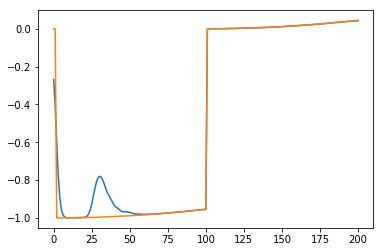

In [30]:
plt.plot(predictions_mean)
plt.plot(true_mean)

---

### Test-Set Result(s): 

In [31]:
print("Building Test Set Performance Metrics")

# Initialize Wasserstein-1 Error Distribution
W1_errors_test = np.array([])
Mean_errors_test = np.array([])
Var_errors_test = np.array([])
Skewness_errors_test = np.array([])
Kurtosis_errors_test = np.array([])
# Initialize Prediction Metrics
predictions_mean_test = np.array([])
true_mean_test = np.array([])
#---------------------------------------------------------------------------------------------#

# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_test_list)-1)):    
    # Get Laws
    W1_loop_test = ot.emd2_1d(Barycenters_Array,
                         np.array(measures_locations_test_list[x_i]).reshape(-1,),
                         Predicted_Weights_test[x_i,].reshape(-1,),
                         measure_weights_test.reshape(-1,))
    W1_errors_test = np.append(W1_errors_test,W1_loop_test)
    # Get Means
    Mu_hat_test = np.sum((Predicted_Weights_test[x_i])*(Barycenters_Array))
    Mu_test = np.mean(np.array(measures_locations_test_list[x_i]))
    Mean_errors_test = np.append(Mean_errors_test,(Mu_hat_test-Mu_test))
    ## Update Predictions
    predictions_mean_test = np.append(predictions_mean_test,Mu_hat_test)
    true_mean_test = np.append(true_mean_test,Mu_test)
    # Get Var (non-centered)
    Var_hat_test = np.sum((Barycenters_Array**2)*(Predicted_Weights_test[x_i]))
    Var_test = np.mean(np.array(measures_locations_test_list[x_i])**2)
    Var_errors_test = np.append(Var_errors_test,(Var_hat_test-Var_test)**2)
    # Get skewness (non-centered)
    Skewness_hat_test = np.sum((Barycenters_Array**3)*(Predicted_Weights_test[x_i]))
    Skewness_test = np.mean(np.array(measures_locations_test_list[x_i])**3)
    Skewness_errors_test = np.append(Skewness_errors_test,(abs(Skewness_hat_test-Skewness_test))**(1/3))
    # Get skewness (non-centered)
    Kurtosis_hat_test = np.sum((Barycenters_Array**4)*(Predicted_Weights_test[x_i]))
    Kurtosis_test = np.mean(np.array(measures_locations_test_list[x_i])**4)
    Kurtosis_errors_test = np.append(Kurtosis_errors_test,(abs(Kurtosis_hat_test-Kurtosis_test))**.25)
    
#---------------------------------------------------------------------------------------------#
# Compute Error Statistics/Descriptors
W1_Performance_test = np.array([np.min(np.abs(W1_errors_test)),np.mean(np.abs(W1_errors_test)),np.mean(np.abs(W1_errors_test))])
Mean_prediction_Performance_test = np.array([np.min(np.abs(Mean_errors_test)),np.mean(np.abs(Mean_errors_test)),np.mean(np.abs(Mean_errors_test))])
Var_prediction_Performance_test = np.array([np.min(np.abs(Var_errors_test)),np.mean(np.abs(Var_errors_test)),np.mean(np.abs(Var_errors_test))])
Skewness_prediction_Performance_test = np.array([np.min(np.abs(Skewness_errors_test)),np.mean(np.abs(Skewness_errors_test)),np.mean(np.abs(Skewness_errors_test))])
Kurtosis_prediction_Performance_test = np.array([np.min(np.abs(Kurtosis_errors_test)),np.mean(np.abs(Kurtosis_errors_test)),np.mean(np.abs(Kurtosis_errors_test))])

Type_A_Prediction_test = pd.DataFrame({"W1":W1_Performance_test,
                                  "E[X']-E[X]":Mean_prediction_Performance_test,
                                  "(E[X'^2]-E[X^2])^.5":Var_prediction_Performance_test,
                                  "(E[X'^3]-E[X^3])^(1/3)":Skewness_prediction_Performance_test,
                                  "(E[X'^4]-E[X^4])^.25":Kurtosis_prediction_Performance_test},index=["Min","MAE","Max"])

# Write Performance
Type_A_Prediction_test.to_latex((results_tables_path+str("Roughness_")+str(Rougness)+str("__RatiofBM_")+str(Ratio_fBM_to_typical_vol)+
 "__TypeAPrediction_Test.tex"))

  0%|          | 0/51 [00:00<?, ?it/s]

Building Test Set Performance Metrics


100%|██████████| 51/51 [00:11<00:00,  4.39it/s]


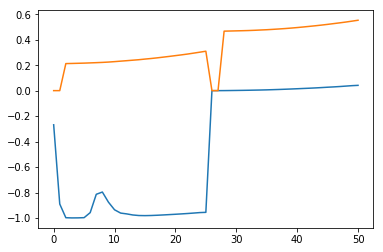

In [32]:
plt.plot(predictions_mean_test)
plt.plot(true_mean_test)

## Update User

### Print for Terminal Legibility

In [33]:
print("#----------------------#")
print("Training-Set Performance")
print("#----------------------#")
print(Type_A_Prediction)
print(" ")
print(" ")
print(" ")

print("#------------------#")
print("Test-Set Performance")
print("#------------------#")
print(Type_A_Prediction_test)
print(" ")
print(" ")
print(" ")

#----------------------#
Training-Set Performance
#----------------------#
               W1  E[X']-E[X]  (E[X'^2]-E[X^2])^.5  (E[X'^3]-E[X^3])^(1/3)  \
Min  2.106408e-07    0.000005         1.642695e-12                0.004462   
MAE  1.875395e-02    0.020944         3.965892e-03                0.124760   
Max  4.055521e-01    0.405331         1.644725e-01                0.740400   

     (E[X'^4]-E[X^4])^.25  
Min              0.010853  
MAE              0.181392  
Max              0.798396  
 
 
 
#------------------#
Test-Set Performance
#------------------#
           W1  E[X']-E[X]  (E[X'^2]-E[X^2])^.5  (E[X'^3]-E[X^3])^(1/3)  \
Min  0.000269    0.000003         7.257290e-08                0.042301   
MAE  0.820610    0.806614         4.082910e-01                0.727934   
Max  0.820610    0.806614         4.082910e-01                0.727934   

     (E[X'^4]-E[X^4])^.25  
Min              0.093343  
MAE              0.732286  
Max              0.732286  
 
 
 


### Facts of Simulation Experiment:

In [34]:
# Update User
print("====================")
print(" Experiment's Facts ")
print("====================")
print("------------------------------------------------------")
print("=====")
print("Model")
print("=====")
print("\u2022 N Centers:",N_Quantizers_to_parameterize)
print("\u2022 Each Wasserstein-1 Ball should contain: ",
      N_Elements_Per_Cluster, 
      "elements from the training set.")
print("------------------------------------------------------")
print("========")
print("Training")
print("========")
print("\u2022 Data-size:",(len(x_Grid)*len(t_Grid)))
print("\u2022 N Points per training datum:",N_Monte_Carlo_Samples)
print("------------------------------------------------------")
print("=======")
print("Testing")
print("=======")
print("\u2022 Data-size Test:",(len(x_Grid_test)*len(t_Grid_test)))
print("\u2022 N Points per testing datum:",N_Monte_Carlo_Samples_Test)
print("------------------------------------------------------")
print("------------------------------------------------------")

 Experiment's Facts 
------------------------------------------------------
=====
Model
=====
• N Centers: 101
• Each Wasserstein-1 Ball should contain:  2 elements from the training set.
------------------------------------------------------
Training
• Data-size: 202
• N Points per training datum: 10000
------------------------------------------------------
Testing
• Data-size Test: 52
• N Points per testing datum: 10000
------------------------------------------------------
------------------------------------------------------


### Training-Set Performance

In [35]:
Type_A_Prediction

,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
Min,2.106408e-07,0.000005,1.642695e-12,0.004462,0.010853
MAE,1.875395e-02,0.020944,3.965892e-03,0.124760,0.181392
Max,4.055521e-01,0.405331,1.644725e-01,0.740400,0.798396


### Test-Set Performance

In [36]:
Type_A_Prediction_test

,W1,E[X']-E[X],(E[X'^2]-E[X^2])^.5,(E[X'^3]-E[X^3])^(1/3),(E[X'^4]-E[X^4])^.25
Min,0.000269,0.000003,7.257290e-08,0.042301,0.093343
MAE,0.820610,0.806614,4.082910e-01,0.727934,0.732286
Max,0.820610,0.806614,4.082910e-01,0.727934,0.732286


# Visualization

In [37]:
# Get Testing Predictions
Mu_hat = np.array([])
Mu = np.array([])
# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_list)-1)):    
    # Get Laws
    Mu_hat = np.append(Mu_hat,np.sum((Predicted_Weights[x_i])*(Barycenters_Array)))
    Mu = np.append(Mu,np.mean(np.array(measures_locations_list[x_i])))

# Get Training Predictions
Mu_hat_test = np.array([])
Mu_test = np.array([])
Var_hat_test = np.array([])
# Populate Error Distribution
for x_i in tqdm(range(len(measures_locations_test_list)-1)):    
    # Get Laws
    Mu_hat_test = np.append(Mu_hat_test,np.sum((Predicted_Weights_test[x_i])*(Barycenters_Array)))
    Mu_test = np.append(Mu_test,np.mean(np.array(measures_locations_test_list[x_i])))
    ## Error Bands
    Var_hat_test = np.append(Var_hat_test,np.sqrt(np.sum((Barycenters_Array**2)*(Predicted_Weights_test[x_i]))))

100%|██████████| 51/51 [00:00<00:00, 176.74it/s]


---

---
# Fin
---

---